# 07MIAR_Proyecto_Programación - Plant Seedlings Classification

### Preparación de los datos

In [1]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive
BASE_FOLDER = "/content/drive/MyDrive/BASE_FOLDER/"
DATASET=BASE_FOLDER+ "my_dataset/ohe_data_train_resize_224.h5"

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import json
import pandas as pd

In [4]:
df = pd.read_hdf(DATASET,key='data')

## ResNet50

In [5]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, BatchNormalization

In [6]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np

model=ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [7]:
for layer in model.layers[:-10]:
    layer.trainable = False

# Agregar nuevas capas para adaptar el modelo a tu tarea
x = model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Agregar Dropout
x = BatchNormalization()(x)  # Agregar BatchNormalization
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)  # Agregar Dropout
x = BatchNormalization()(x)  # Agregar BatchNormalization
x = Dense(12, activation='softmax')(x)

# Combinar el modelo base y las nuevas capas
model = Model(inputs=model.input, outputs=x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Suponiendo que 'X' contiene las imágenes y 'Y' contiene las etiquetas

# Convertir X a un arreglo NumPy
X = np.array(df['imagen'].tolist())
Y = df.iloc[:, 1:]  # Selecciona todas las columnas excepto la primera (X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#X_test, X_test_val, Y_test, Y_test_val = train_test_split(X_test, Y_test, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(3800, 224, 224, 3)
(950, 224, 224, 3)
(3800, 12)
(950, 12)


In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,  # Rango de rotación en grados
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    zoom_range=0.2,  # Rango de zoom
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest'  # Estrategia de relleno para píxeles nuevos creados
)

# Preparar el generador de datos para el conjunto de entrenamiento
train_generator = datagen.flow(X_train, Y_train, batch_size=45)

In [ ]:
import tensorflow as tf
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.1 * 0.9**x)
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(X_train) // 32,  # Número de pasos por época
#     epochs=50,
#     ,  # Proporciona los datos de validación
#     callbacks=[reduce_lr]
# )
history_1=model.fit(train_generator, epochs=40,verbose=2,validation_data=(X_test, Y_test),callbacks=[reduce_lr])

Epoch 1/40
85/85 - 39s - loss: 2.3544 - accuracy: 0.1861 - val_loss: 2.2076 - val_accuracy: 0.2337 - lr: 0.1000 - 39s/epoch - 455ms/step
Epoch 2/40
85/85 - 39s - loss: 2.4336 - accuracy: 0.1539 - val_loss: 2.7549 - val_accuracy: 0.1316 - lr: 0.0900 - 39s/epoch - 454ms/step
Epoch 3/40
85/85 - 39s - loss: 2.5109 - accuracy: 0.1124 - val_loss: 2.5065 - val_accuracy: 0.1147 - lr: 0.0810 - 39s/epoch - 454ms/step
Epoch 4/40
85/85 - 39s - loss: 2.4814 - accuracy: 0.1129 - val_loss: 2.4970 - val_accuracy: 0.1316 - lr: 0.0729 - 39s/epoch - 455ms/step
Epoch 5/40
85/85 - 39s - loss: 2.4726 - accuracy: 0.1279 - val_loss: 2.4375 - val_accuracy: 0.1316 - lr: 0.0656 - 39s/epoch - 456ms/step
Epoch 6/40
85/85 - 38s - loss: 2.4603 - accuracy: 0.1308 - val_loss: 2.4541 - val_accuracy: 0.1042 - lr: 0.0590 - 38s/epoch - 452ms/step
Epoch 7/40
85/85 - 39s - loss: 2.4564 - accuracy: 0.1253 - val_loss: 2.4565 - val_accuracy: 0.1042 - lr: 0.0531 - 39s/epoch - 456ms/step
Epoch 8/40


In [35]:
import tensorflow as tf

#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01 * 0.9**x)

print("[INFO] Entrenando Red Neuronal...")
history_1=model.fit(X_train, Y_train, epochs=40,verbose=2,validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, Y_test)
print("\nTest accuracy:", test_acc)

[INFO] Entrenando Red Neuronal...
Epoch 1/40
95/95 - 11s - loss: 1.3551 - accuracy: 0.3829 - val_loss: 1.5202 - val_accuracy: 0.3539 - 11s/epoch - 119ms/step
Epoch 2/40
95/95 - 11s - loss: 1.3502 - accuracy: 0.3832 - val_loss: 1.5213 - val_accuracy: 0.3539 - 11s/epoch - 120ms/step
Epoch 3/40


KeyboardInterrupt: 

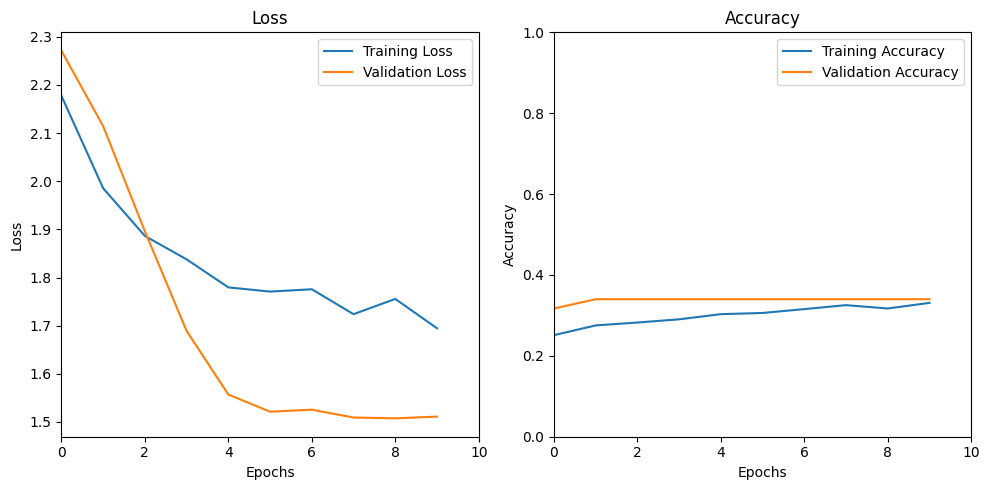

In [42]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))

    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['loss']))  # Establece límites para el eje x
    plt.legend()

    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['accuracy']))  # Establece límites para el eje x
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)